# Analyzing Quasar Spectra with Dimensionality Reduction

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapters 10-11 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*


## Introduction

Quasars are among the most luminous objects in the universe. These distant active galactic nuclei, powered by supermassive black holes actively accreting matter, provide unique laboratories for studying fundamental astrophysics across cosmic time. As material spirals into the black hole, it forms an accretion disk that heats to extreme temperatures, emitting intense radiation across the electromagnetic spectrum.

The spectroscopic study of quasars reveals a wealth of information about both the quasars themselves and the universe through which their light travels. When light from distant quasars traverses billions of light-years to reach us, it encounters clouds of neutral hydrogen in the intergalactic medium. These interactions create the distinctive Lyman-α forest—a series of absorption lines that encode information about the distribution and properties of matter along the line of sight. By analyzing these features, astronomers can effectively perform "tomography" of the universe, mapping the cosmic web in three dimensions and studying the evolution of large-scale structure.

Beyond probing the intergalactic medium, quasar spectra provide insights into the chemical composition and physical conditions in distant galaxies through metal absorption lines. The continuum shape and emission line properties reveal information about the accretion physics and black hole masses. Furthermore, the statistical properties of quasar spectra across different redshifts help constrain cosmological parameters and the expansion history of the universe, making them powerful tools for precision cosmology.

In this tutorial, we explore how statistical machine learning techniques can help us understand the complex information encoded in quasar spectra. Despite the apparent complexity of these spectra—each containing thousands of wavelength bins—the underlying physics constrains the variation to a much lower-dimensional manifold. This insight motivates our use of dimensionality reduction techniques to extract the essential information from these high-dimensional observations.

We'll develop a comprehensive framework that combines Principal Component Analysis (PCA) to identify the primary modes of spectral variation and achieve efficient data compression, Gaussian Mixture Models (GMM) to characterize the distribution of quasars in the reduced parameter space, generative modeling to create synthetic quasar spectra for testing analysis pipelines, and outlier detection to identify unusual objects that may represent rare phenomena or data quality issues. This approach demonstrates how unsupervised learning methods can reveal structure in astronomical data without requiring labeled training sets—a crucial capability when dealing with the vast datasets produced by modern astronomicalsurveys.

## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Python Programming**: Working knowledge of NumPy, matplotlib, and scipy for scientific computing
- **Linear Algebra**: Understanding of eigenvalue decomposition, matrix operations, and orthogonal transformations
- **Probability Theory**: Basic understanding of multivariate Gaussian distributions and mixture models
- **Spectroscopy Basics**: Elementary knowledge of astronomical spectra and emission/absorption features

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Dimensionality Reduction**: Applying PCA to high-dimensional spectral data and interpreting the physical meaning of principal components
- **Data Compression**: Quantifying the trade-offs between compression ratio and reconstruction accuracy
- **Mixture Modeling**: Using Gaussian Mixture Models to characterize distributions in reduced parameter spaces
- **Generative Modeling**: Creating synthetic astronomical data that preserves the statistical properties of real observations
- **Anomaly Detection**: Identifying outliers in high-dimensional data through probabilistic methods

Let's begin by setting up our computational environment and loading the quasar spectral dataset:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

# Configure plotting parameters for publication-quality figures
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## Loading and Exploring the Quasar Dataset

Our dataset contains quasar spectra that have been processed to extract the continuum emission, removing the complex absorption features of the Lyman-α forest. This preprocessing allows us to focus on the underlying patterns in quasar continua, which encode information about the accretion disk physics and black hole properties.

Each spectrum consists of flux measurements at 2,947 wavelength bins, spanning the rest-frame ultraviolet and optical regions where quasars emit most strongly. Let's load the data and examine its structure:

In [2]:
# Load the quasar spectral dataset
data = np.load("data_quasar_sample.npz")
X = data["continua"]
wavelength = data["wavelength"]

print("Available data arrays:", data.files)
print(f"Spectral data shape: {X.shape}")
print(f"Number of quasars: {X.shape[0]}")
print(f"Number of wavelength bins: {X.shape[1]}")
print(f"Wavelength range: {wavelength.min():.1f} - {wavelength.max():.1f} Å")

Available data arrays: ['continua', 'wavelength']
Spectral data shape: (1000, 2947)
Number of quasars: 1000
Number of wavelength bins: 2947
Wavelength range: 1030.0 - 2029.7 Å


### Visualizing Representative Quasar Continua

To understand the structure of our data, let's examine several representative quasar continua. It's important to note that these spectra have already been processed to extract only the continuum emission—the smooth underlying spectrum produced by the accretion disk. The complex absorption features from the Lyman-α forest and metal lines have been removed, allowing us to focus on the fundamental emission properties of the quasars themselves:

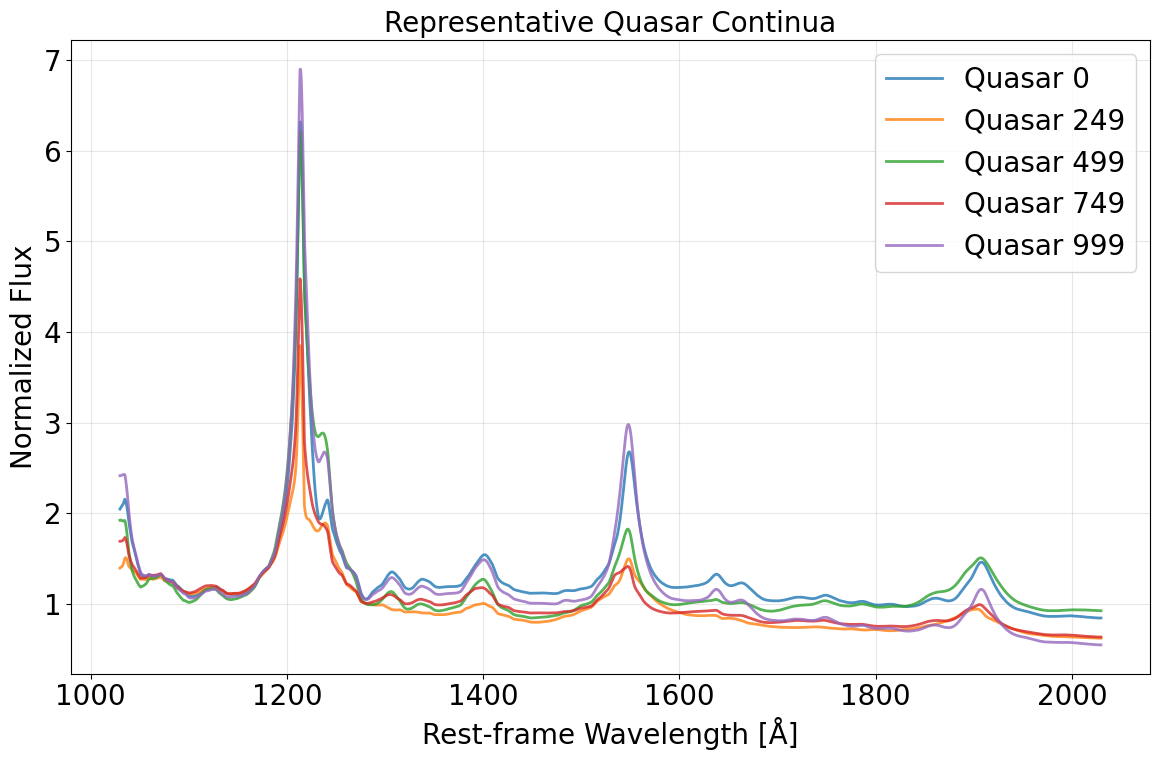

In [3]:
# Plot a selection of quasar continua
fig, ax = plt.subplots(figsize=(12, 8))

# Select every 200th spectrum to show variety without overcrowding
n_examples = 5
indices = np.linspace(0, len(X)-1, n_examples, dtype=int)

for i, idx in enumerate(indices):
    ax.plot(wavelength, X[idx], alpha=0.8, linewidth=2, 
            label=f'Quasar {idx}')

ax.set_xlabel('Rest-frame Wavelength [Å]')
ax.set_ylabel('Normalized Flux')
ax.set_title('Representative Quasar Continua')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The plot above displays several representative quasar continua from our dataset. Each curve represents a different quasar's continuum spectrum, showing how the flux varies across different wavelengths. Several important features are evident:

**Lyman-α Emission Line**: The prominent peak around 1215 Å is the Lyman-α emission line, one of the strongest features in quasar spectra. This emission occurs when electrons in hydrogen atoms transition from the n=2 to n=1 energy level in the broad-line region surrounding the black hole.

**Power-Law Continuum**: The underlying continuum shape follows an approximate power law, produced by the multi-temperature blackbody emission from the accretion disk. The spectral slope encodes information about the accretion rate and black hole mass.

**Other Emission Features**: Additional peaks at longer wavelengths correspond to other emission lines, including C IV (1549 Å) and other metal transitions. These features provide diagnostics of the gas temperature, density, and metallicity in the quasar environment.

It's crucial to understand that these are simulated continua generated from models with a finite number of parameters for pedagogical purposes. This makes them somewhat idealized compared to real observations. While they capture the primary modes of variation in quasar spectra, real continua would exhibit additional subtle variabilities from instrumental effects, atmospheric variations, and small-scale physical processes not captured in the simulations. This controlled nature actually benefits our analysis—it allows us to test dimensionality reduction techniques on data where we expect a relatively small number of principal components to capture most of the variance.

The high dimensionality of these spectra (2,947 wavelength bins) presents an interesting case study. Since these are simulated from a model with limited degrees of freedom, we expect Principal Component Analysis to achieve very efficient compression—potentially reducing thousands of dimensions to just a handful while preserving all the information. This makes the dataset ideal for demonstrating the power of dimensionality reduction in astronomy.

## Principal Component Analysis for Spectral Compression

Principal Component Analysis (PCA) provides a powerful framework for analyzing high-dimensional spectral data. By identifying the directions of maximum variance in our dataset, PCA can reveal the fundamental patterns that characterize quasar spectra while achieving dramatic data compression.

Each quasar spectrum in our dataset contains 2,947 flux measurements. Storing and analyzing such high-dimensional data presents significant computational challenges, especially when dealing with millions of spectra from modern surveys. However, the physics of quasar emission suggests that the intrinsic dimensionality is much lower. The continuum shape is primarily determined by a few key parameters: the black hole mass, accretion rate, viewing angle, and dust extinction. Similarly, emission line strengths depend on the ionization state and kinematics of the broad-line region.

PCA exploits this structure by finding a new coordinate system where the data variance is concentrated along a small number of axes. These principal components often have clear physical interpretations, making PCA not just a compression tool but also a method for understanding the underlying physics.

### Implementing PCA with Singular Value Decomposition

Let's apply PCA to our quasar spectra using Singular Value Decomposition (SVD), which provides a numerically stable and efficient implementation:

In [4]:
# First, we need to center the data by subtracting the mean spectrum
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean

# Perform SVD on the centered data
# X = U @ S @ V.T, where V contains the principal components
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

# Calculate the explained variance for each component
# The variance is proportional to the square of singular values
explained_variance = S**2 / (len(X) - 1)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Create the PCA components (eigenvectors)
components = Vt

print(f"Shape of U: {U.shape}")
print(f"Shape of S: {S.shape}")
print(f"Shape of components: {components.shape}")
print(f"\nTotal variance explained by first 10 components: {cumulative_variance_ratio[9]:.4f}")

Shape of U: (1000, 1000)
Shape of S: (1000,)
Shape of components: (1000, 2947)

Total variance explained by first 10 components: 1.0000


### Analyzing Variance Explained by Principal Components

A key step in PCA is determining how many components to retain. By examining the cumulative variance explained, we can identify the point of diminishing returns where additional components contribute negligible information:

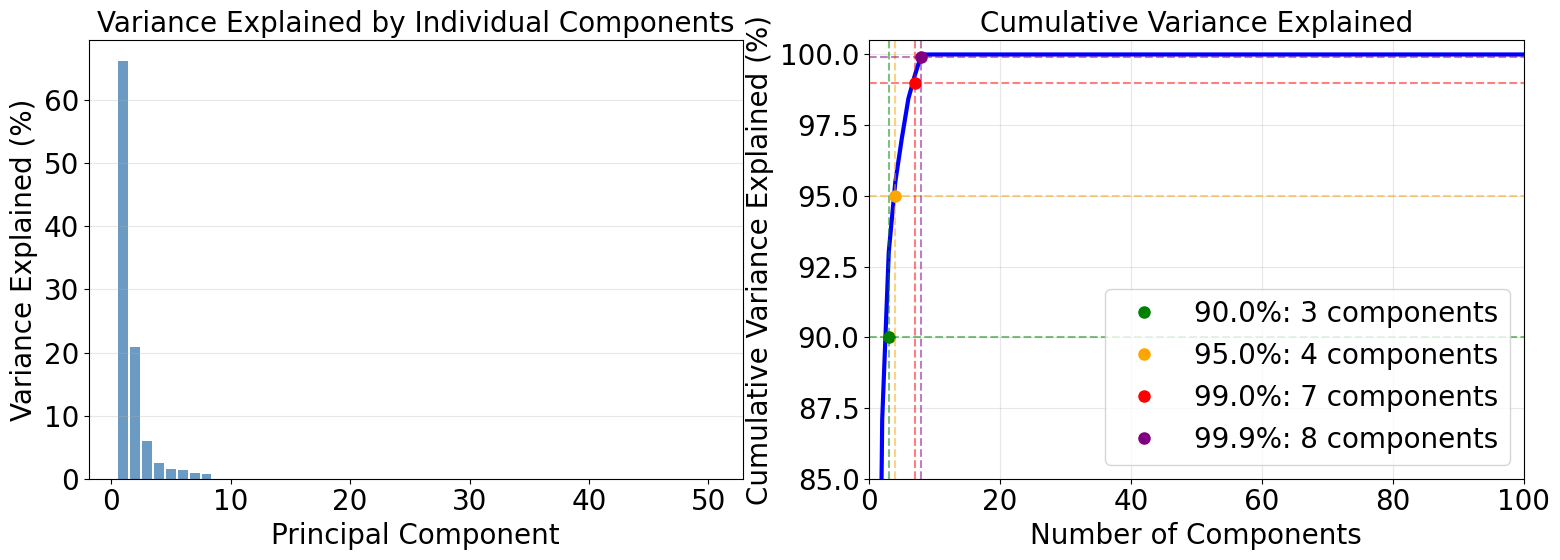

To capture 90.0% variance: 3 components needed (compression ratio: 982.3x)
To capture 95.0% variance: 4 components needed (compression ratio: 736.8x)
To capture 99.0% variance: 7 components needed (compression ratio: 421.0x)
To capture 99.9% variance: 8 components needed (compression ratio: 368.4x)


In [5]:
# Plot the cumulative variance explained
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left panel: Individual variance explained by each component
n_components_to_show = 50
ax1.bar(range(1, n_components_to_show + 1), 
        explained_variance_ratio[:n_components_to_show] * 100, 
        color='steelblue', alpha=0.8)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained (%)')
ax1.set_title('Variance Explained by Individual Components')
ax1.grid(True, alpha=0.3, axis='y')

# Right panel: Cumulative variance explained
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), 
         cumulative_variance_ratio * 100, 
         'b-', linewidth=3)

# Mark key thresholds
thresholds = [0.90, 0.95, 0.99, 0.999]
colors = ['green', 'orange', 'red', 'purple']
for threshold, color in zip(thresholds, colors):
    n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
    ax2.axhline(threshold * 100, color=color, linestyle='--', alpha=0.5)
    ax2.axvline(n_components, color=color, linestyle='--', alpha=0.5)
    ax2.plot(n_components, threshold * 100, 'o', color=color, markersize=8,
             label=f'{threshold*100:.1f}%: {n_components} components')

ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained (%)')
ax2.set_title('Cumulative Variance Explained')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 100)
ax2.set_ylim(85, 100.5)

plt.tight_layout()
plt.show()

# Print summary statistics
for threshold in thresholds:
    n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
    compression_ratio = X.shape[1] / n_components
    print(f"To capture {threshold*100:.1f}% variance: {n_components} components needed "
          f"(compression ratio: {compression_ratio:.1f}x)")

### Interpreting the Variance Distribution

The variance analysis reveals the extraordinary compressibility of these quasar spectra. The results are striking: just 3 components capture 90% of the variance, and only 8 components are needed to capture 99.9%. This represents compression ratios of nearly 1000× while preserving the essential information. Such extreme efficiency confirms that these simulated spectra were indeed generated from a low-dimensional model.

For comparison, real observational data would typically require more components due to instrumental noise, atmospheric effects, and additional physical variations not captured in the simulations. Nevertheless, even real quasar spectra can often be well-represented with 20-50 components—still a dramatic reduction from thousands of wavelength bins.

This efficient compression has profound practical implications. For large spectroscopic surveys containing millions of spectra, storing just 8 PCA coefficients per object instead of 2,947 flux values reduces storage requirements by a factor of 368 while preserving 99.9% of the information. This enables entire surveys to be kept in memory for rapid analysis, transforming what would be a big data problem into a manageable one.

To evaluate the quality of PCA compression, let's reconstruct spectra using different numbers of components and examine the trade-off between compression ratio and reconstruction accuracy. Given the extreme efficiency we've observed, we'll test reconstructions with very few components:

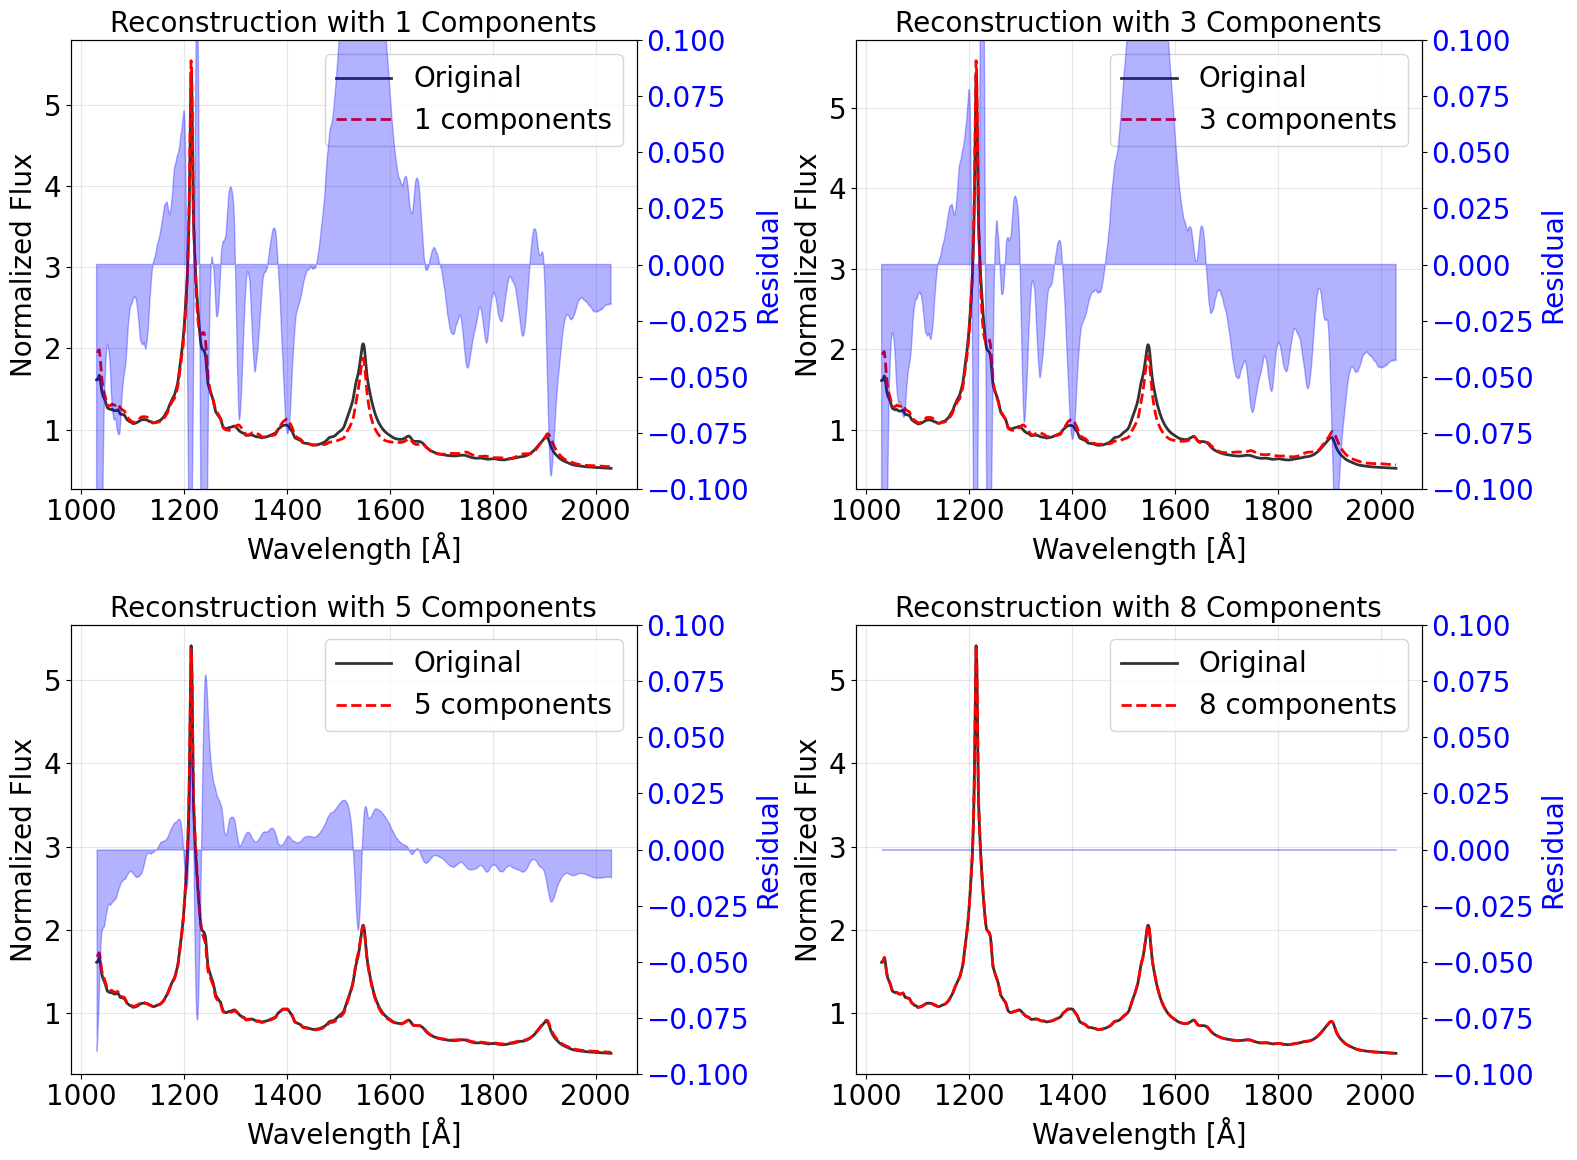

In [6]:
# Select a test spectrum to reconstruct
test_idx = 100
test_spectrum = X[test_idx]
test_spectrum_centered = X_centered[test_idx]

# Calculate PCA coefficients for this spectrum
# Project onto the principal components
pca_coefficients = test_spectrum_centered @ components.T

# Reconstruct using different numbers of components
# Given the extreme efficiency, we'll use very few components
n_components_list = [1, 3, 5, 8]
reconstructions = {}
mse_values = {}

for n_comp in n_components_list:
    # Reconstruct using first n_comp components
    reconstruction_centered = pca_coefficients[:n_comp] @ components[:n_comp]
    reconstruction = reconstruction_centered + X_mean
    reconstructions[n_comp] = reconstruction
    
    # Calculate mean squared error
    mse = np.mean((test_spectrum - reconstruction)**2)
    mse_values[n_comp] = mse

# Plot original spectrum and reconstructions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, n_comp in enumerate(n_components_list):
    ax = axes[i]
    
    # Plot original and reconstruction
    ax.plot(wavelength, test_spectrum, 'k-', linewidth=2, 
            label='Original', alpha=0.8)
    ax.plot(wavelength, reconstructions[n_comp], 'r--', linewidth=2,
            label=f'{n_comp} components')
    
    # Add residual plot in the background
    residual = test_spectrum - reconstructions[n_comp]
    ax_twin = ax.twinx()
    ax_twin.fill_between(wavelength, residual, alpha=0.3, color='blue')
    ax_twin.set_ylabel('Residual', color='blue')
    ax_twin.tick_params(axis='y', labelcolor='blue')
    ax_twin.set_ylim(-0.1, 0.1)
    
    # Get variance explained for this number of components
    var_explained = cumulative_variance_ratio[n_comp-1] * 100
    
    # Formatting
    ax.set_xlabel('Wavelength [Å]')
    ax.set_ylabel('Normalized Flux')
    ax.set_title(f'Reconstruction with {n_comp} Components')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The reconstruction analysis demonstrates the effectiveness of PCA compression on these simulated spectra. Even with just a single component, the basic continuum shape is captured. By the time we use 3 components (capturing 90% of variance), the reconstruction is nearly indistinguishable from the original, with residuals at the level of a few percent. With 8 components (99.9% variance), the reconstruction is essentially perfect.

The residuals (shown in blue) reveal what information is lost at each compression level. With very few components, we miss some of the detailed structure in emission lines and continuum curvature. As we add components, these features are progressively recovered. This hierarchical reconstruction reflects how PCA orders information by importance—the most significant spectral features are encoded in the first few components.

### Physical Interpretation of Principal Components

The principal components themselves often have clear physical interpretations. Let's examine the first few components to understand what aspects of quasar spectra they encode:

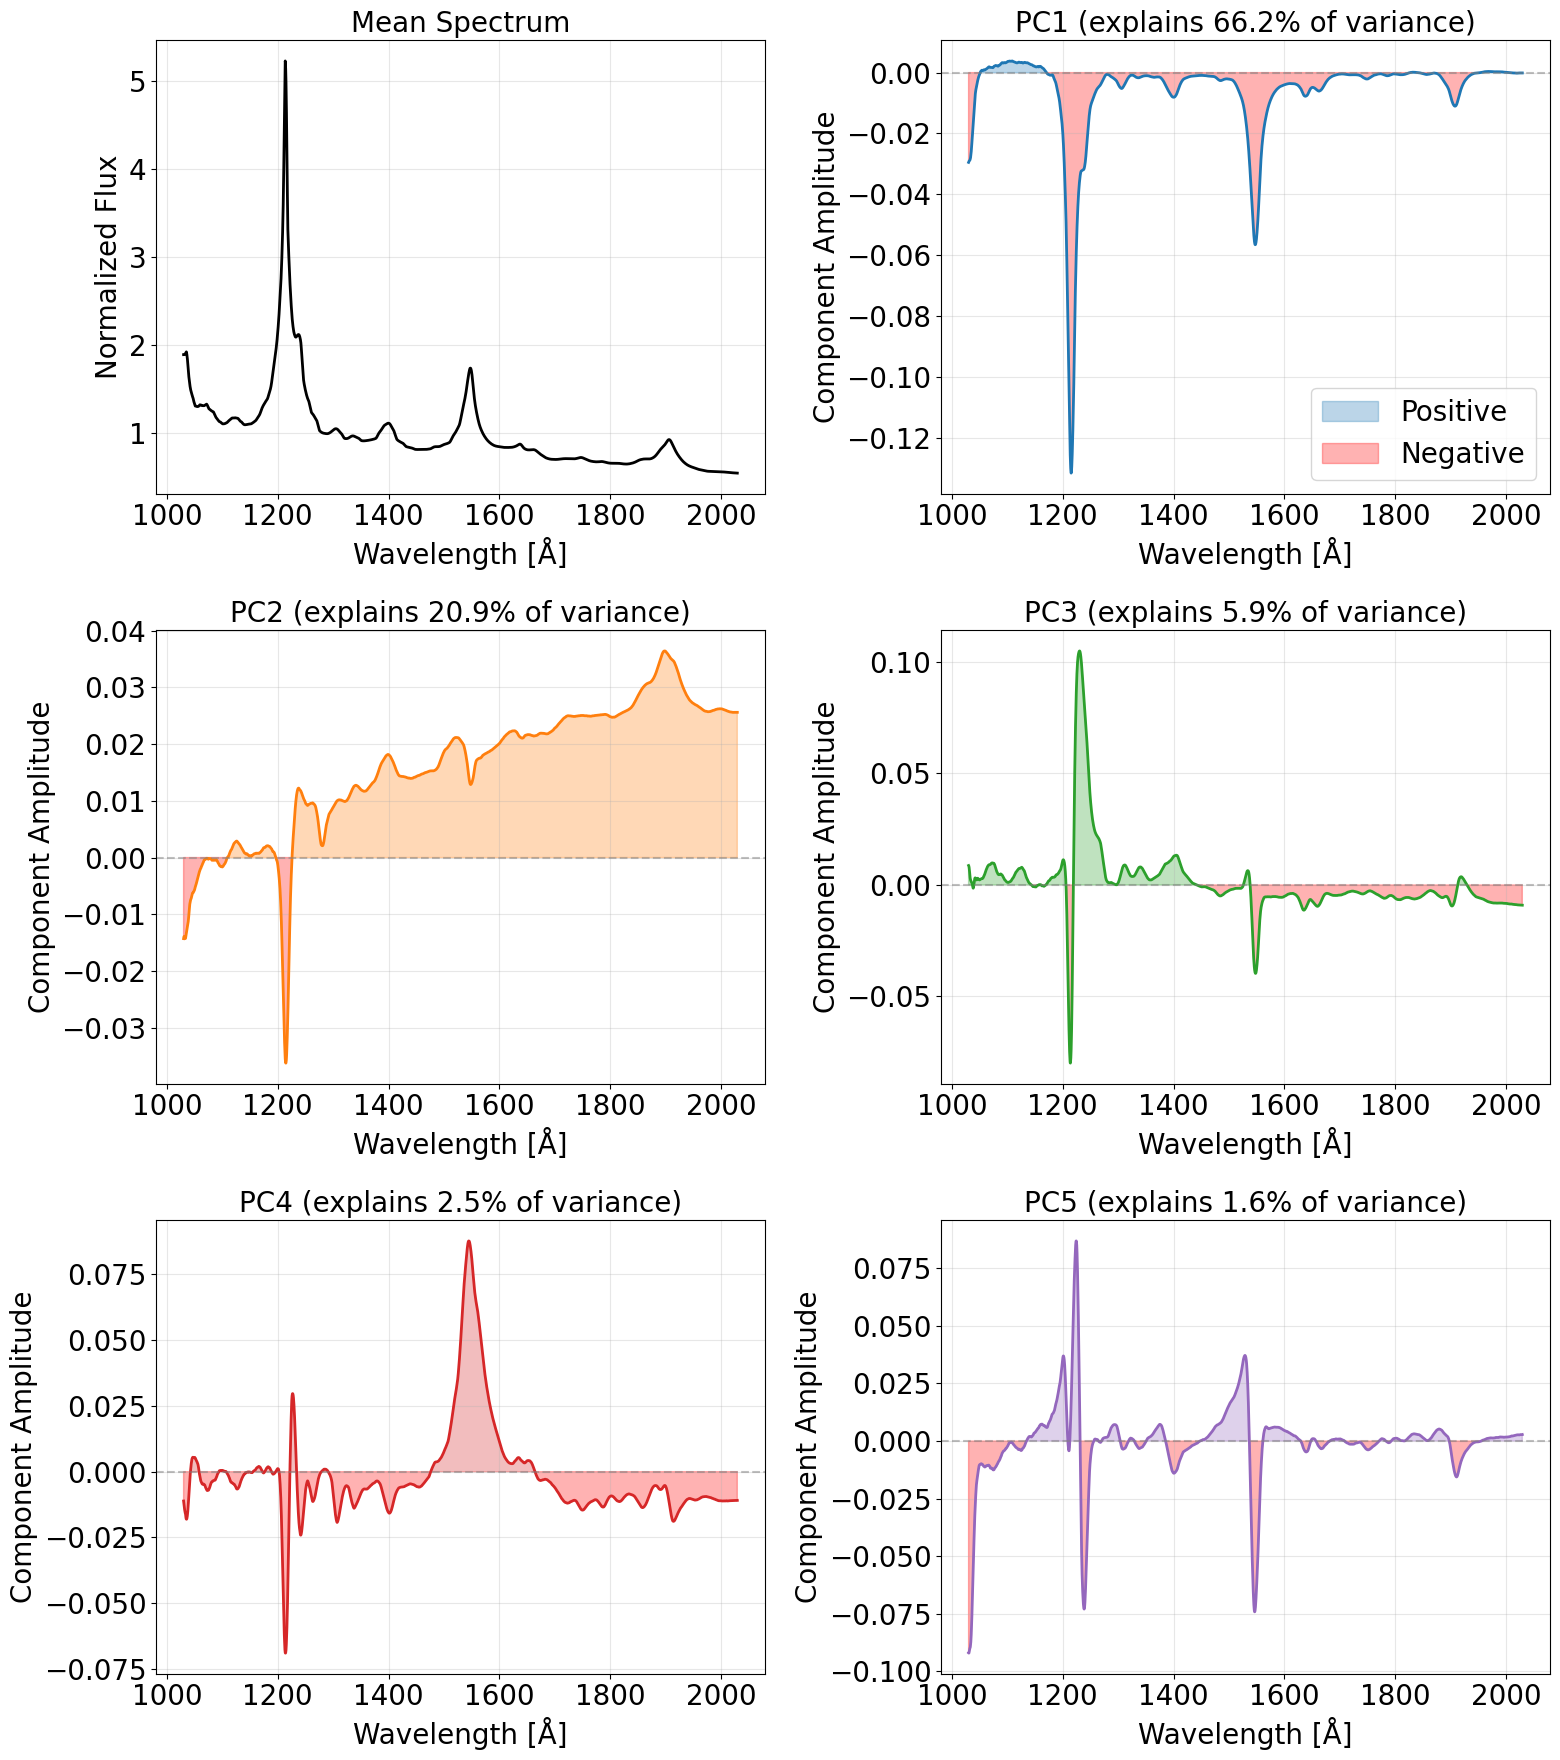

In [7]:
# Plot the first few principal components and the mean spectrum
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Plot the mean spectrum
ax = axes[0, 0]
ax.plot(wavelength, X_mean, 'k-', linewidth=2)
ax.set_xlabel('Wavelength [Å]')
ax.set_ylabel('Normalized Flux')
ax.set_title('Mean Spectrum')
ax.grid(True, alpha=0.3)

# Plot the first 5 principal components
for i in range(5):
    ax = axes[(i+1)//2, (i+1)%2]
    
    # Plot the component
    ax.plot(wavelength, components[i], linewidth=2, color=f'C{i}')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Add shading to show positive/negative regions
    ax.fill_between(wavelength, components[i], where=(components[i] > 0), 
                    alpha=0.3, color=f'C{i}', label='Positive')
    ax.fill_between(wavelength, components[i], where=(components[i] < 0), 
                    alpha=0.3, color='red', label='Negative')
    
    # Formatting
    ax.set_xlabel('Wavelength [Å]')
    ax.set_ylabel('Component Amplitude')
    ax.set_title(f'PC{i+1} (explains {explained_variance_ratio[i]*100:.1f}% of variance)')
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()


### Physical Interpretation of Principal Components

The principal components reveal a clear hierarchy of spectral variations in our quasar dataset:

**Mean Spectrum**: Shows the average quasar continuum with prominent Lyα (1215 Å) and C IV (1549 Å) emission lines, plus additional features. The continuum follows the expected power-law shape with a gradual decline toward longer wavelengths.

**PC1 (66.2% of variance)**: Dominated by strong negative features at all emission lines, particularly Lyα and C IV. This component captures the primary mode of variation—differences in overall emission line strength relative to the continuum. Quasars with positive PC1 coefficients have weaker emission lines, while those with negative coefficients have stronger lines.

**PC2 (20.9% of variance)**: Shows a broad, tilted continuum component that rises toward longer wavelengths, with additional negative spikes at emission lines. This appears to capture variations in continuum slope or color, possibly related to dust reddening or intrinsic differences in accretion disk temperature.

**PC3 (5.9% of variance)**: Features a dramatic positive peak at Lyα contrasted with a negative feature at C IV. This component encodes the relative strength of Lyα versus metal lines, potentially reflecting variations in the hydrogen-to-metal line ratios or differences in the ionization structure.

**PC4 (2.5% of variance)**: Shows the opposite pattern to PC3—strong positive C IV feature with negative Lyα contribution. Together, PC3 and PC4 allow the model to adjust the relative strengths of different emission lines independently.

**PC5 (1.6% of variance)**: Contains multiple narrow positive and negative features across the spectrum, capturing finer details in the spectral shape and secondary emission line variations.

This component structure makes physical sense: the dominant variation in quasar spectra is the emission line equivalent width (PC1), followed by continuum color (PC2), and then more subtle variations in line ratios (PC3-5). The fact that so few components capture nearly all the variance confirms these are model-generated spectra with limited degrees of freedom and determined by a few key physical processes.

## Gaussian Mixture Models in PCA Space

Having successfully compressed our quasar spectra from thousands of dimensions to just a handful of principal components, we now face a new opportunity. With each quasar represented by only 8 numbers, we can efficiently model the distribution of quasars in this reduced parameter space.

Gaussian Mixture Models (GMM) provide a flexible framework for characterizing complex distributions. By modeling the quasar population as a mixture of Gaussian components, we can:
- Identify distinct subpopulations or "types" of quasars
- Generate realistic synthetic spectra for testing analysis pipelines
- Detect outliers that may represent unusual physical conditions or data quality issues

First, let's transform our full dataset into PCA space and split it into training and testing sets:

Original data shape: (1000, 2947)
PCA-transformed data shape: (1000, 8)
Compression ratio: 368.4×

Training set size: 800 spectra
Testing set size: 200 spectra


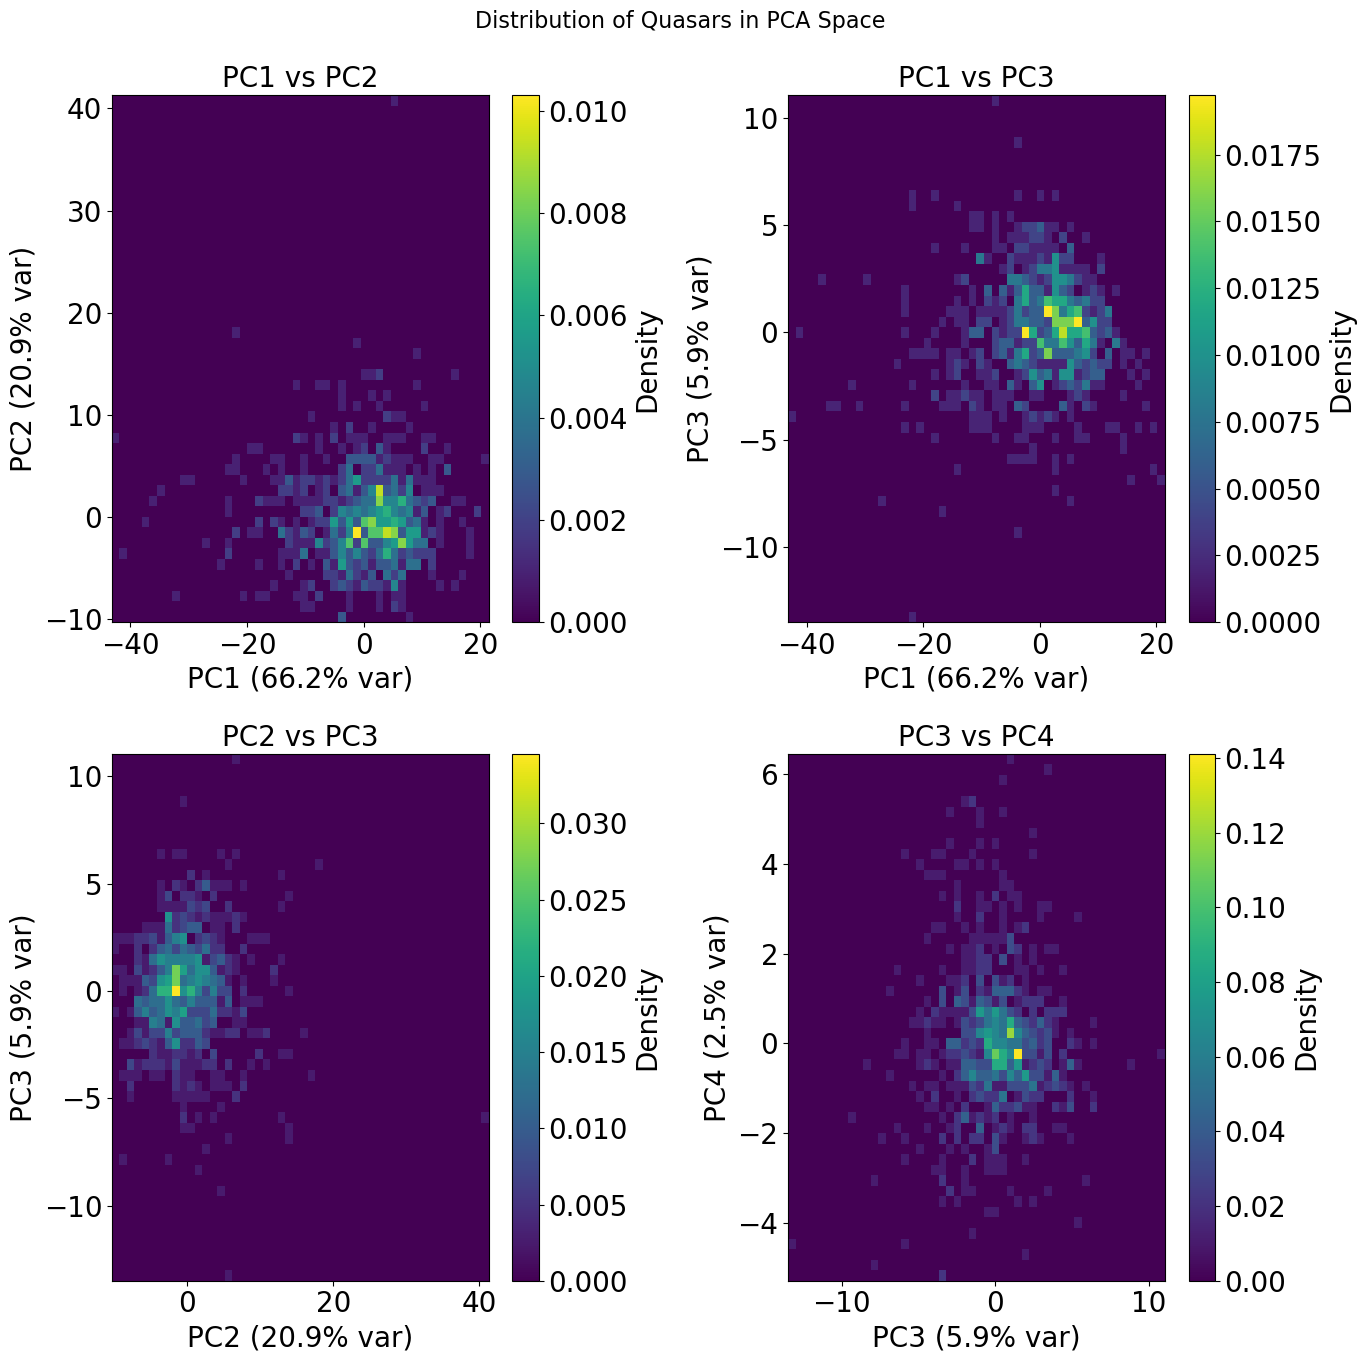

In [8]:
# Choose number of components based on our variance analysis
n_components_pca = 8  # Captures 99.9% of variance

# Project all spectra onto the principal components
X_pca = (X - X_mean) @ components[:n_components_pca].T

print(f"Original data shape: {X.shape}")
print(f"PCA-transformed data shape: {X_pca.shape}")
print(f"Compression ratio: {X.shape[1] / n_components_pca:.1f}×")

# Split into training and testing sets
X_train, X_test = train_test_split(X_pca, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]} spectra")
print(f"Testing set size: {X_test.shape[0]} spectra")

# Visualize the distribution in the first few PC dimensions
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Plot 2D projections of the first 4 components
pc_pairs = [(0, 1), (0, 2), (1, 2), (2, 3)]
pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']

for ax, (pc1, pc2) in zip(axes.ravel(), pc_pairs):
    # Create 2D histogram
    hist = ax.hist2d(X_train[:, pc1], X_train[:, pc2], 
                     bins=50, cmap='viridis', density=True)
    plt.colorbar(hist[3], ax=ax, label='Density')
    
    ax.set_xlabel(f'{pc_labels[pc1]} ({explained_variance_ratio[pc1]*100:.1f}% var)')
    ax.set_ylabel(f'{pc_labels[pc2]} ({explained_variance_ratio[pc2]*100:.1f}% var)')
    ax.set_title(f'{pc_labels[pc1]} vs {pc_labels[pc2]}')

plt.suptitle('Distribution of Quasars in PCA Space', fontsize=16)
plt.tight_layout()
plt.show()

### Model Selection: Balancing Complexity and Generalization

The model selection results reveal an important distinction between different criteria. While AIC continues to decrease with more components (suggesting ever-more complex models), BIC shows a clear minimum, penalizing model complexity more strongly. For our purposes—building a generative model that captures the broad structure of quasar diversity—BIC provides better guidance.

The BIC minimum suggests using a relatively small number of components, which aligns with our goal of identifying the primary modes of quasar variation rather than fitting every detail in the training set. This choice helps ensure our model:
- Captures the essential diversity of quasar spectra without overfitting
- Generates realistic mock spectra that represent the population well
- Provides robust outlier detection by not adapting too closely to training set peculiarities

Let's fit our final GMM using the BIC-optimal number of components:

Fitting GMMs with different numbers of components...
  n_components= 1: train LL=  -16.58, test LL=  -17.47, BIC=26827
  n_components= 2: train LL=  -15.82, test LL=  -16.58, BIC=25915
  n_components= 3: train LL=  -15.65, test LL=  -16.42, BIC=25929
  n_components= 4: train LL=  -15.52, test LL=  -16.37, BIC=26035
  n_components= 5: train LL=  -15.44, test LL=  -16.41, BIC=26195
  n_components= 6: train LL=  -15.36, test LL=  -16.57, BIC=26381
  n_components= 7: train LL=  -15.25, test LL=  -16.60, BIC=26503
  n_components= 8: train LL=  -15.17, test LL=  -16.69, BIC=26674
  n_components= 9: train LL=  -14.97, test LL=  -16.93, BIC=26660
  n_components=10: train LL=  -15.04, test LL=  -16.94, BIC=27069


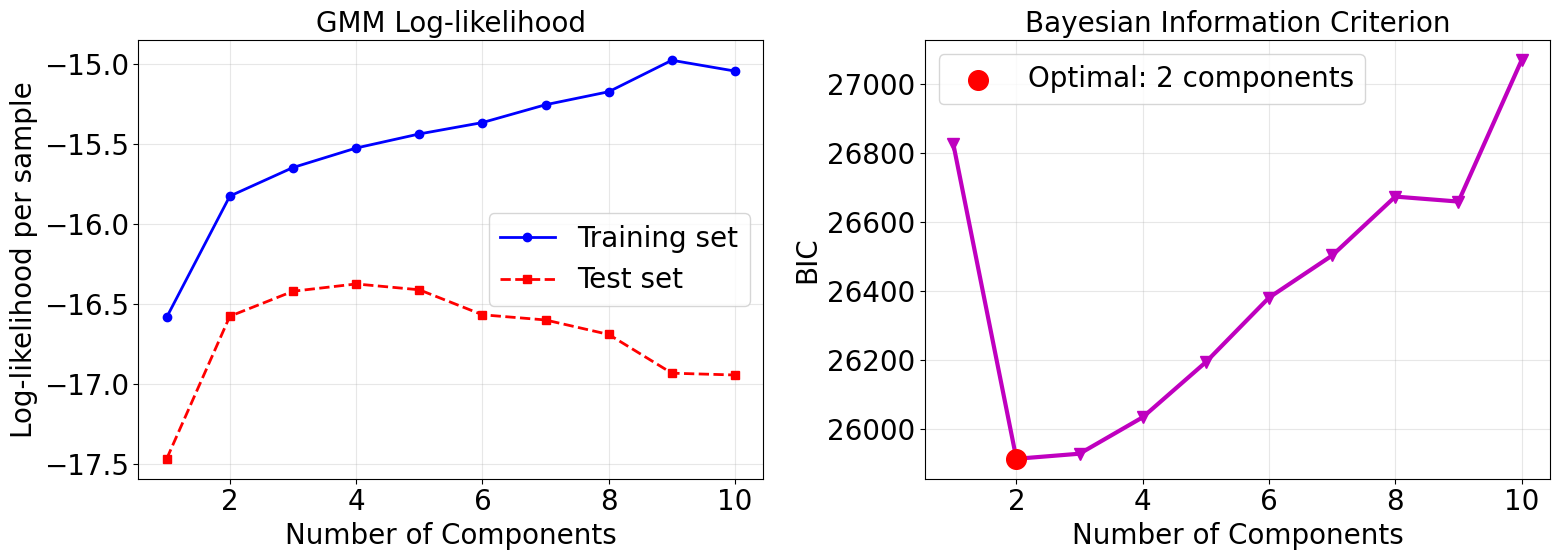


BIC selects 2 components as optimal


In [9]:
# Test different numbers of Gaussian components
n_components_range = range(1, 11) 
n_init = 10  # Number of random initializations for each model

train_scores = []
test_scores = []
bic_scores = []

print("Fitting GMMs with different numbers of components...")
for n_components in n_components_range:
    # Fit GMM with multiple initializations
    gmm = GaussianMixture(n_components=n_components, 
                         covariance_type='full',
                         n_init=n_init,
                         random_state=42)
    
    gmm.fit(X_train)
    
    # Calculate log-likelihood on training and test sets
    train_score = gmm.score(X_train)
    test_score = gmm.score(X_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    # Calculate BIC
    n_features = X_train.shape[1]
    n_samples = X_train.shape[0]
    n_params = (n_components - 1) + n_components * n_features + n_components * n_features * (n_features + 1) // 2
    bic = -2 * train_score * n_samples + n_params * np.log(n_samples)
    bic_scores.append(bic)
    
    print(f"  n_components={n_components:2d}: "
          f"train LL={train_score:8.2f}, test LL={test_score:8.2f}, "
          f"BIC={bic:.0f}")

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left panel: Log-likelihood vs number of components
ax1.plot(n_components_range, train_scores, 'b-', linewidth=2, 
         marker='o', label='Training set')
ax1.plot(n_components_range, test_scores, 'r--', linewidth=2, 
         marker='s', label='Test set')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Log-likelihood per sample')
ax1.set_title('GMM Log-likelihood')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right panel: BIC
ax2.plot(n_components_range, bic_scores, 'm-', linewidth=3, 
         marker='v', markersize=8)

# Mark the minimum
bic_min_idx = np.argmin(bic_scores)
optimal_components = n_components_range[bic_min_idx]
ax2.scatter(optimal_components, bic_scores[bic_min_idx], 
            color='red', s=200, zorder=5,
            label=f'Optimal: {optimal_components} components')

ax2.set_xlabel('Number of Components')
ax2.set_ylabel('BIC')
ax2.set_title('Bayesian Information Criterion')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBIC selects {optimal_components} components as optimal")

The model selection reveals an interesting trade-off. While the log-likelihood plateaus around 4 components, suggesting this captures most of the data's structure, the Bayesian Information Criterion strongly prefers just 2 components. This discrepancy reflects BIC's penalty for model complexity—it's balancing goodness-of-fit against the risk of overfitting.

For our purposes, we'll follow BIC's recommendation of 2 components. This choice reflects our goal of building a robust generative model that captures the broad structure of quasar diversity without memorizing training set details. By using a simpler model, we ensure that generated mock spectra represent the population's main characteristics rather than peculiarities of the training set. Additionally, this simplicity provides clearer outlier detection capabilities by establishing a straightforward baseline for what constitutes a "normal" quasar.

The fact that just 2 Gaussians can reasonably model our quasar population suggests there may be two primary modes of variation—perhaps related to fundamental physical parameters like black hole mass, accretion rate, or evolutionary stage. While a 4-component model might capture more subtle variations, the 2-component model gives us a cleaner, more interpretable framework that's less likely to overfit.

Let's fit our final GMM and examine what these two components represent:

Final GMM with 2 components in 8D PCA space:
  Training log-likelihood: -15.82
  Test log-likelihood: -16.58

Component weights: [0.33621205 0.66378795]


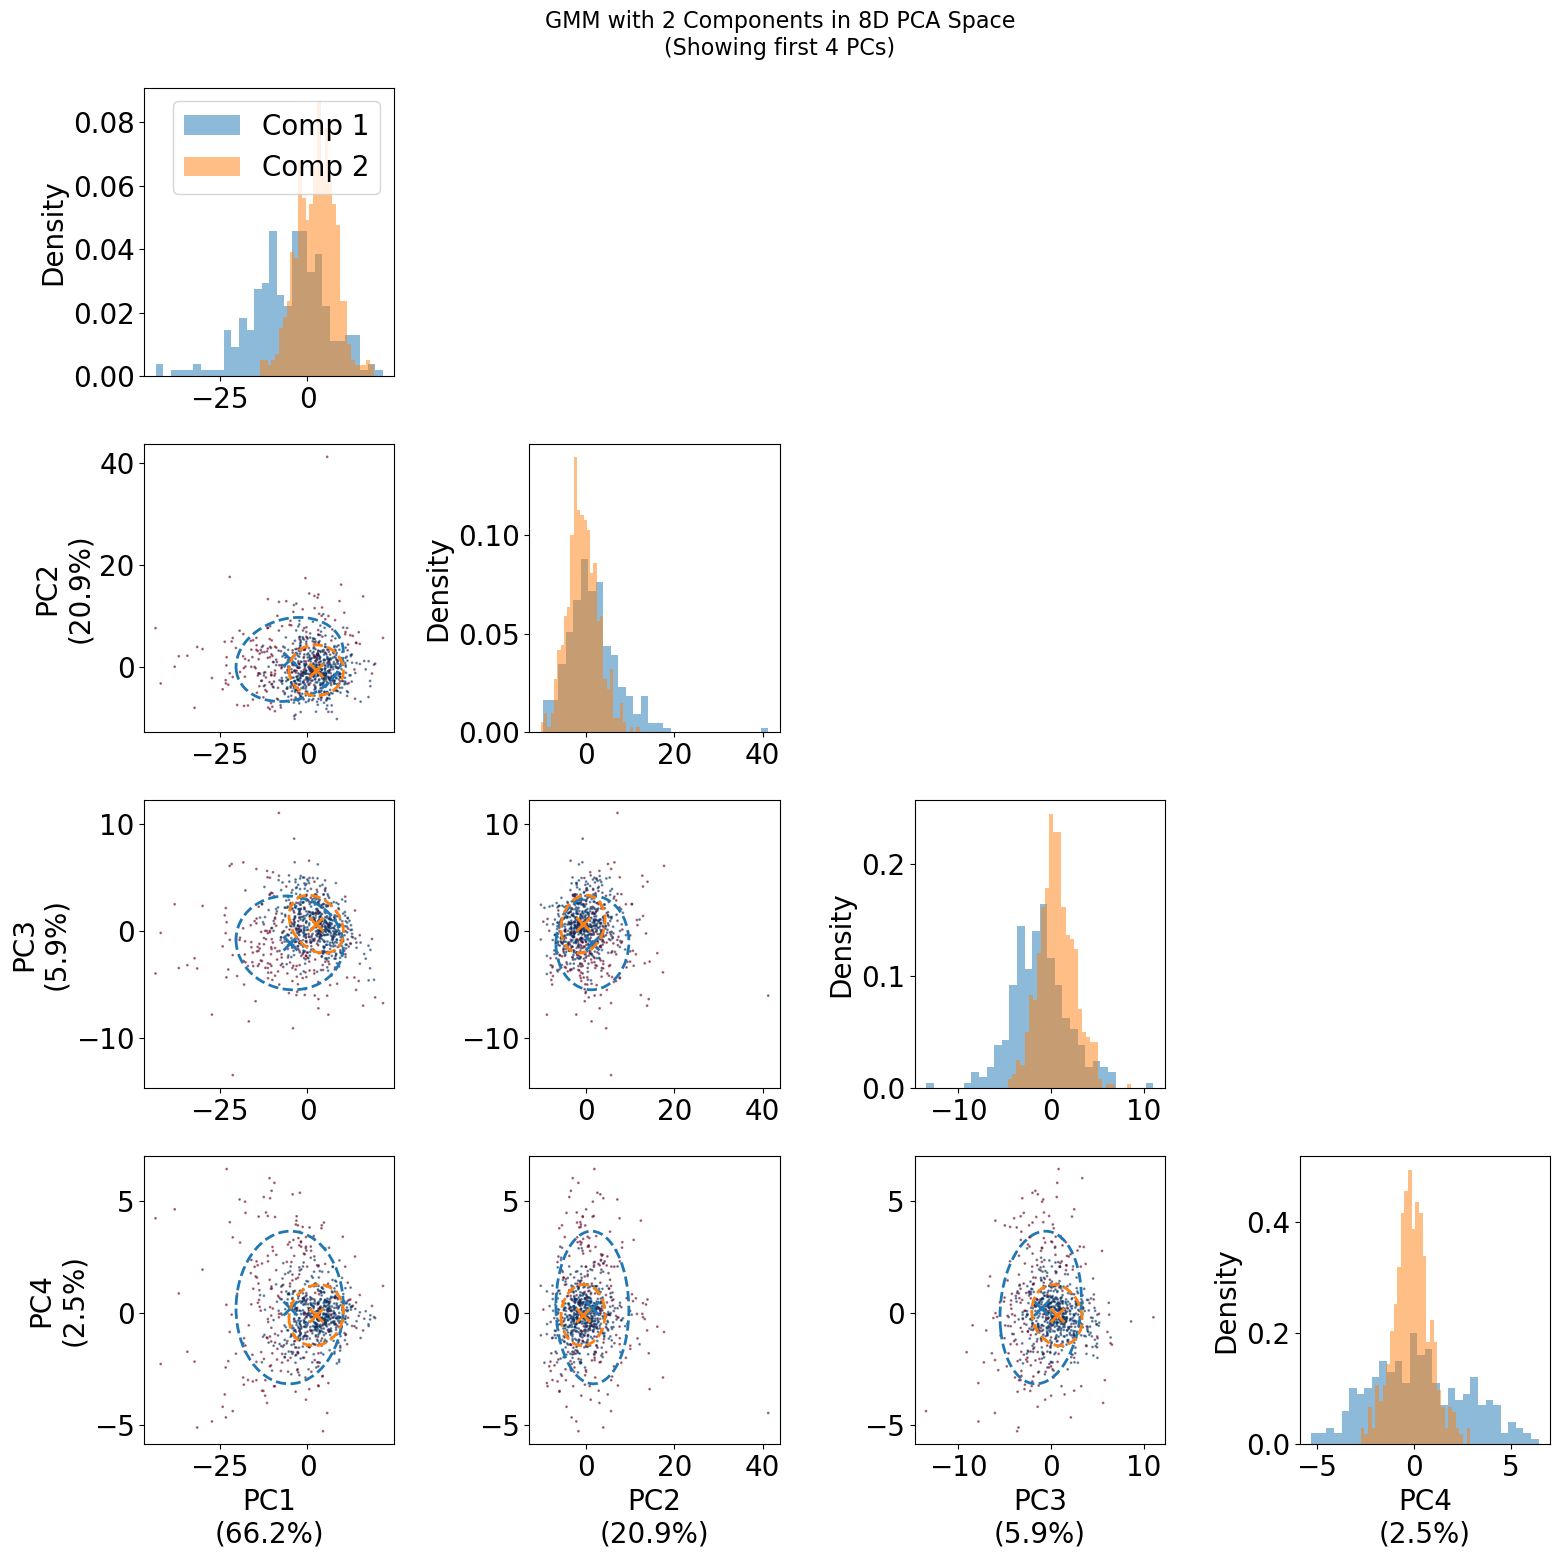


Component statistics:
Component 1: 254 points (31.8%)
Component 2: 546 points (68.2%)


In [10]:
# Fit the final GMM with BIC-optimal number of components
gmm_final = GaussianMixture(n_components=optimal_components,
                           covariance_type='full',
                           n_init=20,  # More initializations for final model
                           random_state=42)

gmm_final.fit(X_train)

# Evaluate final model
train_ll = gmm_final.score(X_train)
test_ll = gmm_final.score(X_test)
print(f"Final GMM with {optimal_components} components in {n_components_pca}D PCA space:")
print(f"  Training log-likelihood: {train_ll:.2f}")
print(f"  Test log-likelihood: {test_ll:.2f}")
print(f"\nComponent weights: {gmm_final.weights_}")

# Assign each training point to its most likely component
component_probs = gmm_final.predict_proba(X_train)
component_assignments = gmm_final.predict(X_train)

# Create a corner plot showing all PCA dimensions
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Plot only the first 4 PCs for clarity (capturing most variance)
n_pcs_to_plot = 4
pc_labels = [f'PC{i+1}' for i in range(n_pcs_to_plot)]

for i in range(n_pcs_to_plot):
    for j in range(n_pcs_to_plot):
        ax = axes[i, j]
        
        if i == j:
            # Diagonal: histograms
            for comp in range(optimal_components):
                mask = component_assignments == comp
                ax.hist(X_train[mask, i], bins=30, alpha=0.5, 
                       density=True, color=f'C{comp}',
                       label=f'Comp {comp+1}' if i == 0 else None)
            ax.set_ylabel('Density')
            if i == 0:
                ax.legend()
        elif j < i:
            # Lower triangle: scatter plots
            # Plot points colored by component
            scatter = ax.scatter(X_train[:, j], X_train[:, i], 
                               c=component_assignments, cmap='RdBu',
                               s=1, alpha=0.5)
            
            # Add component ellipses
            for comp in range(optimal_components):
                mean = gmm_final.means_[comp, [j, i]]
                cov = gmm_final.covariances_[comp][[j, i], :][:, [j, i]]
                
                # Calculate ellipse for 2-sigma contour
                v, w = np.linalg.eigh(cov)
                v = 2. * np.sqrt(2.) * np.sqrt(v)
                angle = np.degrees(np.arctan2(w[0][1], w[0][0]))
                
                from matplotlib.patches import Ellipse
                ell = Ellipse(mean, v[0], v[1], angle=angle,
                            facecolor='none', edgecolor=f'C{comp}', 
                            linewidth=2, linestyle='--')
                ax.add_patch(ell)
                
                # Mark component centers
                ax.scatter(*mean, c=f'C{comp}', s=100, marker='x', linewidth=2)
            
        else:
            # Upper triangle: empty
            ax.set_visible(False)
        
        # Labels
        if i == n_pcs_to_plot - 1:
            ax.set_xlabel(f'{pc_labels[j]}\n({explained_variance_ratio[j]*100:.1f}%)')
        if j == 0 and i > 0:
            ax.set_ylabel(f'{pc_labels[i]}\n({explained_variance_ratio[i]*100:.1f}%)')

plt.suptitle(f'GMM with {optimal_components} Components in {n_components_pca}D PCA Space\n'
             f'(Showing first {n_pcs_to_plot} PCs)', fontsize=16)
plt.tight_layout()
plt.show()

# Print component statistics
print(f"\nComponent statistics:")
for i in range(optimal_components):
    n_points = np.sum(component_assignments == i)
    print(f"Component {i+1}: {n_points} points ({n_points/len(X_train)*100:.1f}%)")

## Generating Synthetic Quasar Spectra

With our trained GMM operating in 8-dimensional PCA space, we can now generate synthetic quasar spectra. The process involves two steps: first sampling new points from the GMM in PCA space, then transforming these back to the full spectral space using the PCA components. This approach ensures that our synthetic spectra respect the learned correlations between different spectral features.

Let's generate a large sample of mock quasar spectra and compare their statistical properties to the original training data:

Generating 1000 synthetic quasar spectra...
Sampled points shape in PCA space: (1000, 8)
Reconstructed spectra shape: (1000, 2947)
Component assignments: [324 676]


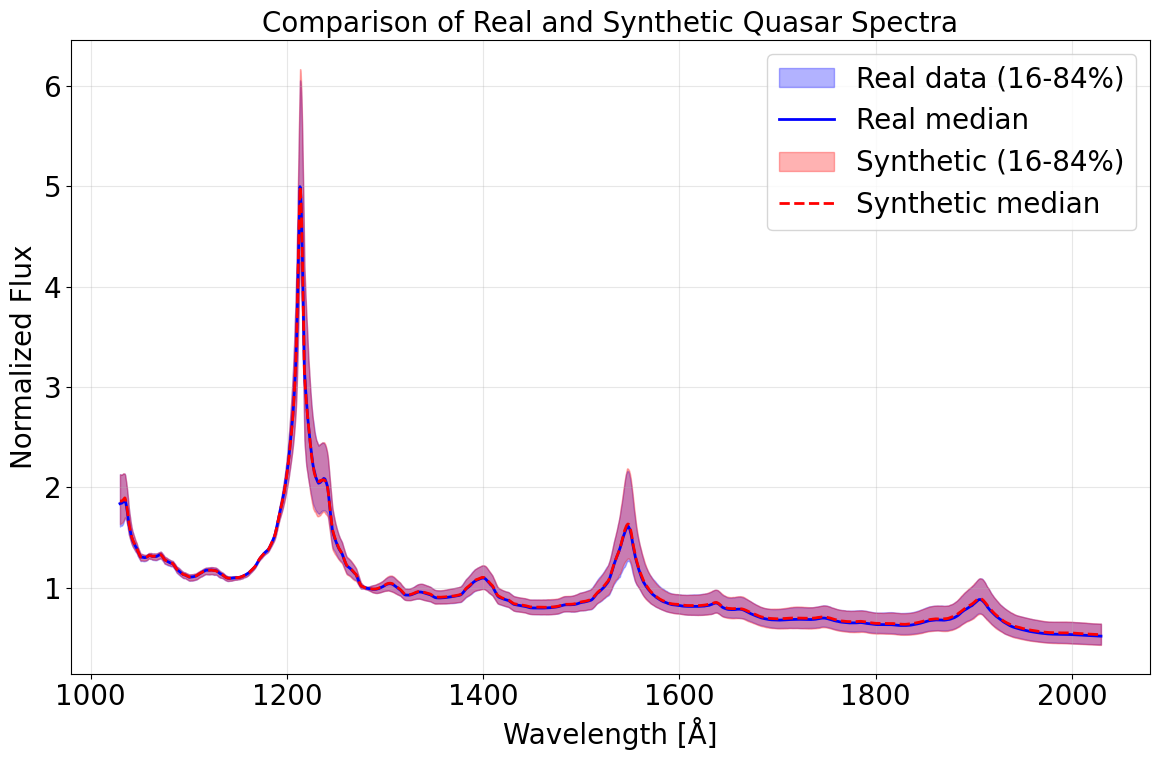

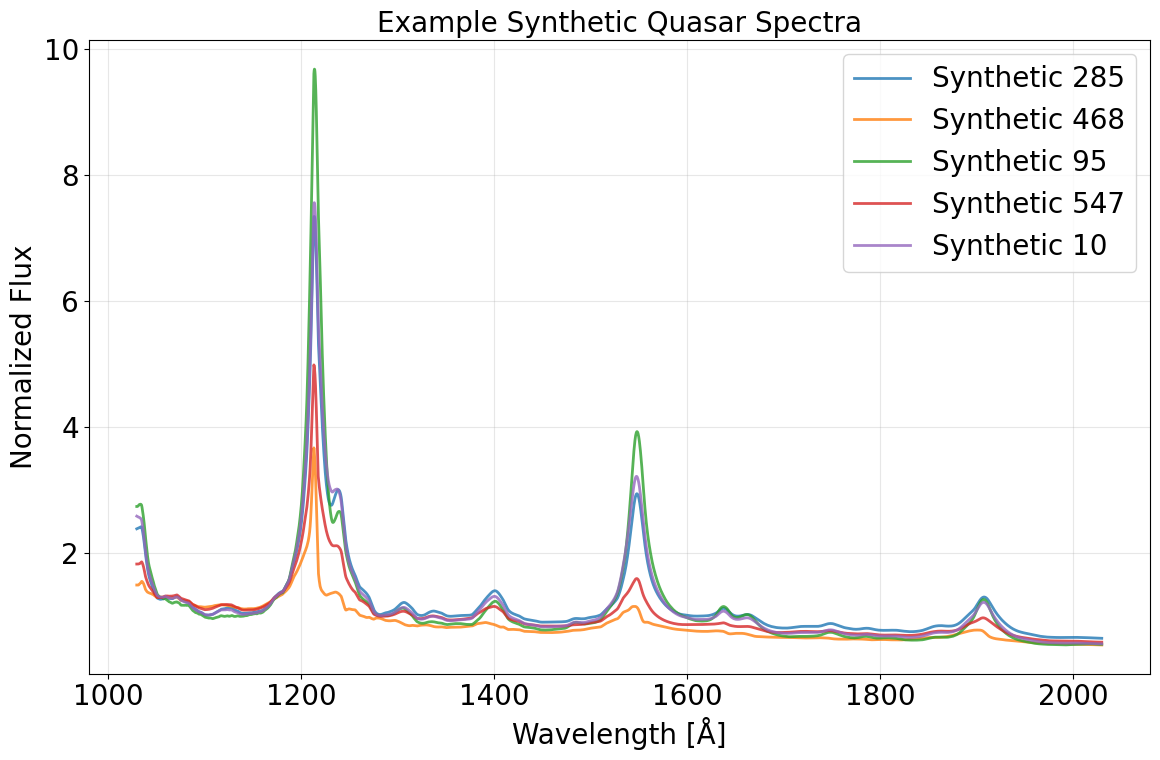

In [14]:
# Generate synthetic quasar spectra
n_synthetic = 1000
print(f"Generating {n_synthetic} synthetic quasar spectra...")

# Sample from the GMM in 8D PCA space
synthetic_pca, component_labels = gmm_final.sample(n_synthetic)
print(f"Sampled points shape in PCA space: {synthetic_pca.shape}")

# Reconstruct full spectra from PCA coefficients
synthetic_spectra = synthetic_pca @ components[:n_components_pca] + X_mean

print(f"Reconstructed spectra shape: {synthetic_spectra.shape}")
print(f"Component assignments: {np.bincount(component_labels)}")

# Get a subset of original training data for comparison
train_indices = np.random.choice(len(X), size=len(X_train), replace=False)
X_train_original = X[train_indices]

# Calculate pixel-wise statistics
percentiles = [16, 50, 84]  # 1-sigma range

# Real data statistics
real_percentiles = np.percentile(X_train_original, percentiles, axis=0)
real_median = real_percentiles[1]
real_lower = real_percentiles[0]
real_upper = real_percentiles[2]

# Synthetic data statistics
synthetic_percentiles = np.percentile(synthetic_spectra, percentiles, axis=0)
synthetic_median = synthetic_percentiles[1]
synthetic_lower = synthetic_percentiles[0]
synthetic_upper = synthetic_percentiles[2]

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 8))

# Plot median and 1-sigma ranges
ax.fill_between(wavelength, real_lower, real_upper, 
                alpha=0.3, color='blue', label='Real data (16-84%)')
ax.plot(wavelength, real_median, 'b-', linewidth=2, label='Real median')

ax.fill_between(wavelength, synthetic_lower, synthetic_upper, 
                alpha=0.3, color='red', label='Synthetic (16-84%)')
ax.plot(wavelength, synthetic_median, 'r--', linewidth=2, label='Synthetic median')

ax.set_xlabel('Wavelength [Å]')
ax.set_ylabel('Normalized Flux')
ax.set_title('Comparison of Real and Synthetic Quasar Spectra')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot a few example synthetic spectra
fig, ax = plt.subplots(figsize=(12, 8))

n_examples = 5
indices = np.random.choice(n_synthetic, n_examples, replace=False)

for i, idx in enumerate(indices):
    component = component_labels[idx]
    ax.plot(wavelength, synthetic_spectra[idx], alpha=0.8, linewidth=2,
            label=f'Synthetic {idx}')

ax.set_xlabel('Wavelength [Å]')
ax.set_ylabel('Normalized Flux')
ax.set_title('Example Synthetic Quasar Spectra')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The comparison shows excellent agreement between real and synthetic spectra. The median spectra and 1-sigma ranges overlap very well across all wavelengths, confirming that our GMM successfully captures the statistical properties of the quasar population. The synthetic spectra exhibit the same characteristic features as real quasars: prominent Lyα and C IV emission lines, realistic continuum shapes, and appropriate levels of variation.

The individual synthetic spectra demonstrate realistic diversity, with variations in emission line strengths and continuum slopes that match observations. This validation gives us confidence that our model can generate realistic mock datasets for testing analysis pipelines or augmenting training sets.

## Outlier Detection with Gaussian Mixture Models

One powerful application of GMMs is identifying outliers—objects that don't fit well within the learned distribution. In the context of quasar spectra, outliers might represent unusual physical conditions (extreme metallicity, peculiar ionization states), rare evolutionary stages or exotic objects, data quality issues or misclassified objects, or interesting astrophysical phenomena worthy of follow-up study.

### Implementing GMM-Based Outlier Detection

The GMM provides a natural framework for outlier detection through the likelihood function. Objects with low likelihood under the model are statistical outliers. Let's implement this approach:

Number of outliers (bottom 1%): 10
Log-likelihood threshold: -26.91
Log-likelihood range: [-66.18, -10.40]


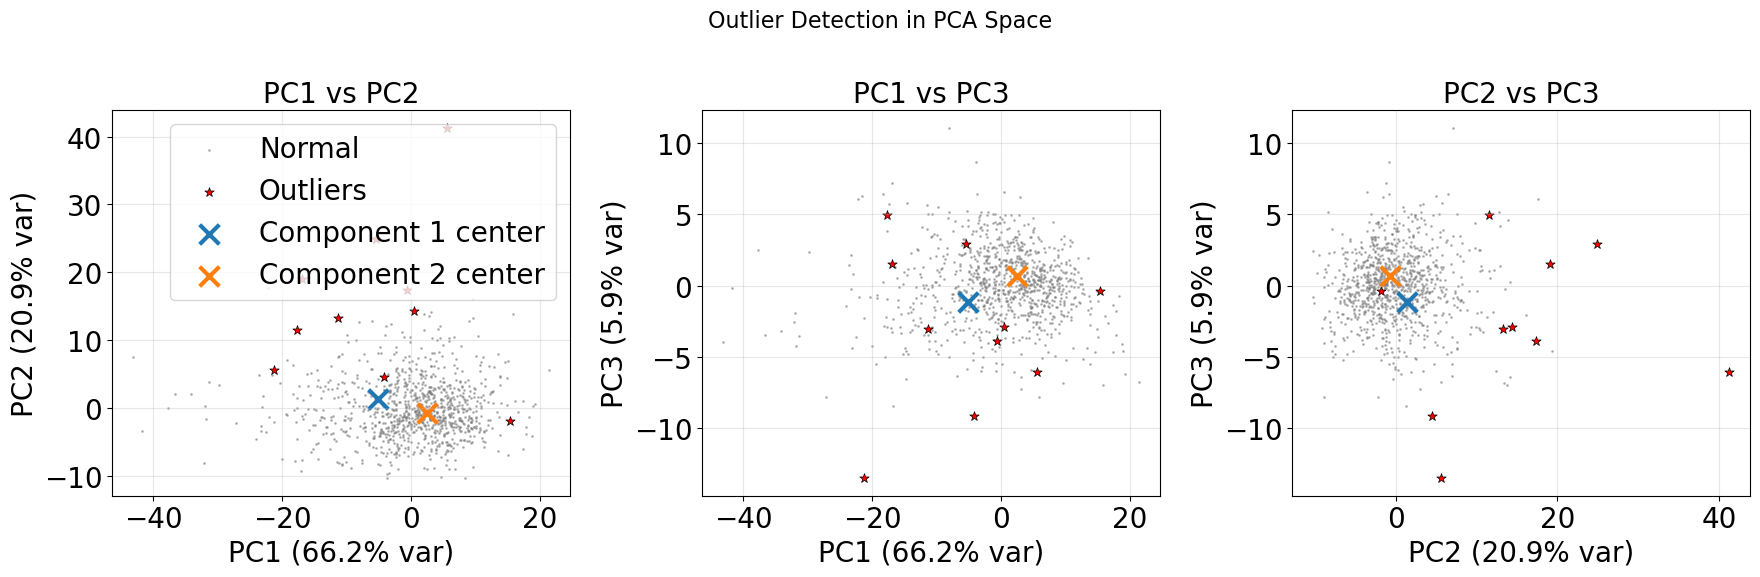

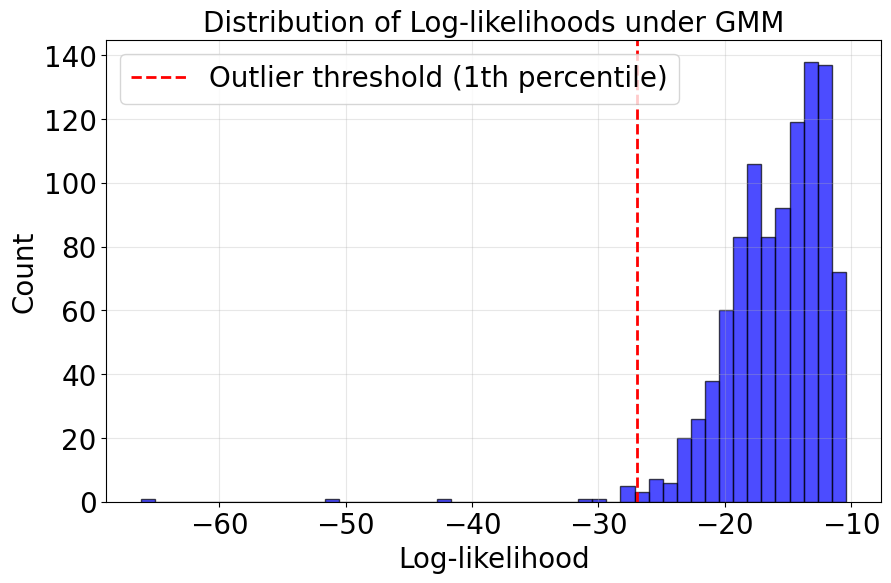

In [15]:
# Calculate log-likelihood for all data points
log_likelihoods = gmm_final.score_samples(X_pca)

# Determine outlier threshold using percentiles
outlier_percentile = 1  # Bottom 1% as outliers
threshold = np.percentile(log_likelihoods, outlier_percentile)

# Identify outliers
is_outlier = log_likelihoods < threshold
n_outliers = np.sum(is_outlier)
outlier_indices = np.where(is_outlier)[0]

print(f"Number of outliers (bottom {outlier_percentile}%): {n_outliers}")
print(f"Log-likelihood threshold: {threshold:.2f}")
print(f"Log-likelihood range: [{log_likelihoods.min():.2f}, {log_likelihoods.max():.2f}]")

# Visualize outliers in PCA space (first 3 components)
fig = plt.figure(figsize=(18, 6))

# Create 3 subplots for different PC pairs
pc_pairs = [(0, 1), (0, 2), (1, 2)]
titles = ['PC1 vs PC2', 'PC1 vs PC3', 'PC2 vs PC3']

for idx, ((pc1, pc2), title) in enumerate(zip(pc_pairs, titles)):
    ax = fig.add_subplot(1, 3, idx + 1)
    
    # Plot normal points
    normal_mask = ~is_outlier
    ax.scatter(X_pca[normal_mask, pc1], X_pca[normal_mask, pc2], 
              c='gray', s=1, alpha=0.5, label='Normal')
    
    # Plot outliers
    ax.scatter(X_pca[is_outlier, pc1], X_pca[is_outlier, pc2], 
              c='red', s=50, marker='*', label='Outliers', edgecolors='black', linewidth=0.5)
    
    # Add GMM component centers
    for i in range(optimal_components):
        ax.scatter(gmm_final.means_[i, pc1], gmm_final.means_[i, pc2], 
                  c=f'C{i}', s=200, marker='x', linewidth=3,
                  label=f'Component {i+1} center' if idx == 0 else None)
    
    ax.set_xlabel(f'PC{pc1+1} ({explained_variance_ratio[pc1]*100:.1f}% var)')
    ax.set_ylabel(f'PC{pc2+1} ({explained_variance_ratio[pc2]*100:.1f}% var)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    if idx == 0:
        ax.legend()

plt.suptitle('Outlier Detection in PCA Space', fontsize=16)
plt.tight_layout()
plt.show()

# Create a histogram of log-likelihoods
plt.figure(figsize=(10, 6))
plt.hist(log_likelihoods, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Outlier threshold ({outlier_percentile}th percentile)')
plt.xlabel('Log-likelihood')
plt.ylabel('Count')
plt.title('Distribution of Log-likelihoods under GMM')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Validating Outliers in Spectral Space

To confirm that our identified outliers are genuinely anomalous, let's examine them in the original spectral domain. We'll compare the outlier spectra against the bulk distribution to understand what makes them unusual:


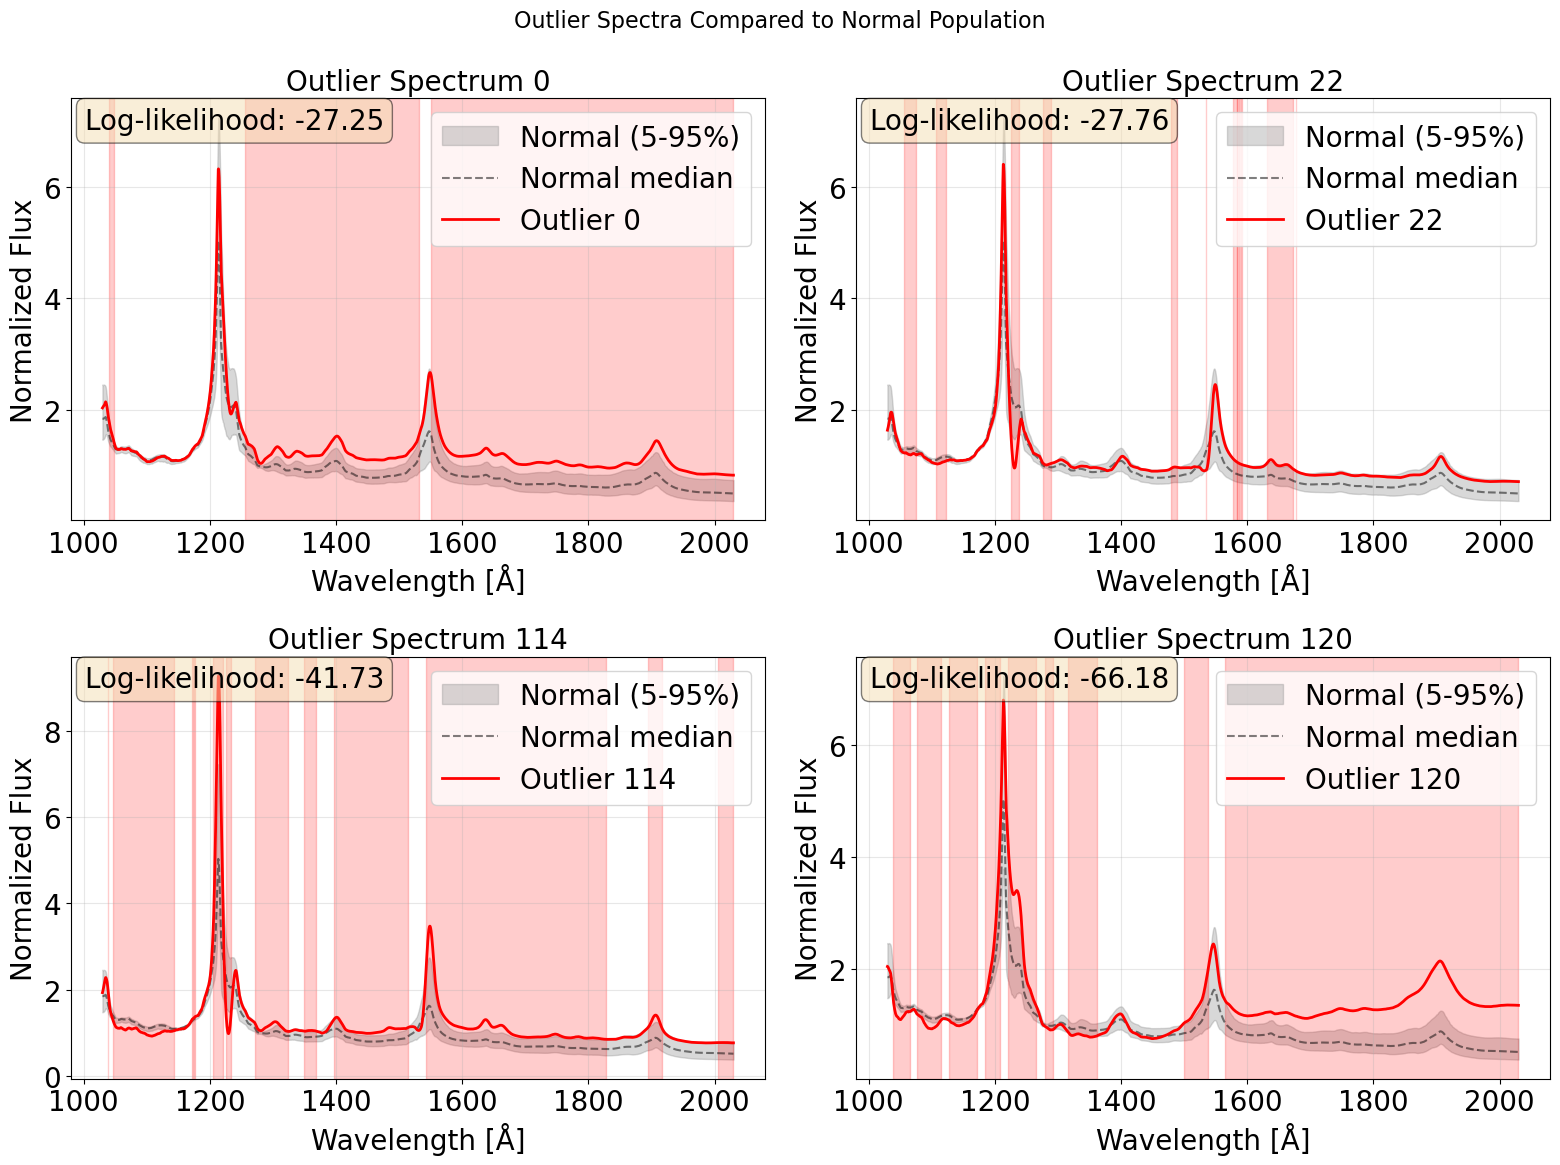


Outlier Analysis:
--------------------------------------------------
Mean PCA coefficients (first 4 components):
Normal: [ 0.05636869 -0.151724    0.02978626  0.02048155]
Outliers: [-5.58050045 15.02067622 -2.94884013 -2.02767373]

Standard deviation of PCA coefficients (first 4 components):
Normal: [8.38938406 4.37142362 2.4604559  1.60717408]
Outliers: [10.85358163 11.44156067  5.31007007  2.48535661]

Mean |z-score| for each PC dimension:
  PC1: 1.18
  PC2: 3.55
  PC3: 1.96
  PC4: 1.79
  PC5: 1.50
  PC6: 3.50
  PC7: 1.94
  PC8: 3.33


In [18]:
# Examine outliers in spectral space
# Calculate 2-sigma range (5th to 95th percentile) for normal spectra
normal_spectra = X[~is_outlier]
percentiles_2sigma = [5, 50, 95]
normal_percentiles = np.percentile(normal_spectra, percentiles_2sigma, axis=0)
normal_lower_2sigma = normal_percentiles[0]
normal_median = normal_percentiles[1]
normal_upper_2sigma = normal_percentiles[2]

# Plot outlier spectra against the normal range
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# Select a few outliers to examine in detail
n_examples = min(4, n_outliers)
example_outliers = outlier_indices[:n_examples]

for i, (ax, outlier_idx) in enumerate(zip(axes, example_outliers)):
    # Plot 2-sigma range of normal spectra
    ax.fill_between(wavelength, normal_lower_2sigma, normal_upper_2sigma,
                   alpha=0.3, color='gray', label='Normal (5-95%)')
    ax.plot(wavelength, normal_median, 'k--', alpha=0.5, label='Normal median')
    
    # Plot the outlier spectrum
    outlier_spectrum = X[outlier_idx]
    ax.plot(wavelength, outlier_spectrum, 'r-', linewidth=2,
            label=f'Outlier {outlier_idx}')
    
    # Highlight regions where outlier is outside 2-sigma range
    outside_range = (outlier_spectrum < normal_lower_2sigma) | (outlier_spectrum > normal_upper_2sigma)
    if np.any(outside_range):
        # Find contiguous regions
        regions = []
        start = None
        for j, is_outside in enumerate(outside_range):
            if is_outside and start is None:
                start = j
            elif not is_outside and start is not None:
                regions.append((start, j-1))
                start = None
        if start is not None:
            regions.append((start, len(outside_range)-1))
        
        # Shade these regions
        for start, end in regions:
            if start <= end and end < len(wavelength):
                ax.axvspan(wavelength[start], wavelength[end], alpha=0.2, color='red')
    
    # Add log-likelihood information
    ll = log_likelihoods[outlier_idx]
    ax.text(0.02, 0.98, f'Log-likelihood: {ll:.2f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Wavelength [Å]')
    ax.set_ylabel('Normalized Flux')
    ax.set_title(f'Outlier Spectrum {outlier_idx}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.suptitle('Outlier Spectra Compared to Normal Population', fontsize=16)
plt.tight_layout()
plt.show()

# Analyze what makes these outliers unusual
print("\nOutlier Analysis:")
print("-" * 50)

# Check PCA coefficients of outliers
outlier_pca = X_pca[is_outlier]
normal_pca = X_pca[~is_outlier]

print("Mean PCA coefficients (first 4 components):")
print(f"Normal: {normal_pca[:, :4].mean(axis=0)}")
print(f"Outliers: {outlier_pca[:, :4].mean(axis=0)}")

print("\nStandard deviation of PCA coefficients (first 4 components):")
print(f"Normal: {normal_pca[:, :4].std(axis=0)}")
print(f"Outliers: {outlier_pca[:, :4].std(axis=0)}")

# Identify which PC dimensions contribute most to outlier status
outlier_z_scores = np.abs((outlier_pca - normal_pca.mean(axis=0)) / normal_pca.std(axis=0))
mean_z_scores = outlier_z_scores.mean(axis=0)
print(f"\nMean |z-score| for each PC dimension:")
for i, z in enumerate(mean_z_scores):
    print(f"  PC{i+1}: {z:.2f}")

The outlier analysis reveals several interesting patterns:

**Spectral Characteristics**: The identified outliers show dramatic deviations from the normal population. Some spectra exhibit extremely strong emission lines (up to 8× the typical flux), while others show unusual continuum shapes or line ratios. The red shaded regions indicate where these spectra fall outside the 2-sigma range of normal quasars, often spanning large wavelength ranges rather than isolated features.

**PCA Space Analysis**: The z-score analysis reveals that PC2, PC6, and PC8 contribute most strongly to outlier identification (z-scores > 3.5). This suggests that the outliers are not just extreme along the primary variance direction (PC1) but show unusual combinations of spectral features captured by higher-order components. The mean PCA coefficients for outliers differ dramatically from the normal population, particularly in PC1 and PC2.

**Physical Interpretation**: These outliers likely represent genuinely unusual quasars rather than data quality issues, given their coherent spectral features. They might include:
- Broad absorption line (BAL) quasars with unusual absorption features
- Quasars with extreme emission line ratios indicating unusual ionization conditions
- Objects with peculiar continuum slopes possibly due to extreme reddening or unusual accretion disk properties
- Potentially misclassified objects (blazars, narrow-line Seyfert 1s, or other AGN types)

The extremely low log-likelihoods (ranging from -27 to -66) confirm that these objects are highly improbable under our simple 2-component Gaussian model, making them excellent candidates for follow-up study or separate classification schemes.

## Summary

This tutorial has demonstrated the power of combining dimensionality reduction with probabilistic modeling for astronomical data analysis. Through the analysis of quasar spectra, we've explored several key concepts that extend throughout statistical machine learning in astronomy:

1. **Extreme Dimensionality Reduction**: We successfully compressed 2,947-dimensional spectra to just 8 principal components while preserving most of the variance. This extraordinary compression ratio reflects the constrained nature of these simulated spectra but illustrates the potential for efficient data representation in astronomy.

2. **Interpretable Components**: The principal components revealed clear physical meaning, with PC1 capturing overall emission line strength, PC2 encoding continuum variations, and higher components representing more subtle line ratio variations. This interpretability makes PCA not just a compression tool but a method for understanding the underlying physics.

3. **Simple but Effective Modeling**: Our 2-component Gaussian Mixture Model, selected through careful model comparison using BIC, successfully captured the primary modes of quasar variation. This simplicity—chosen deliberately over more complex alternatives—ensures robust performance for outlier detection and synthetic data generation.

4. **Validated Generative Capabilities**: The GMM successfully generates realistic synthetic quasar spectra that match the statistical properties of the training data. This capability enables the creation of large mock catalogs for testing analysis pipelines or augmenting limited observational datasets.

5. **Meaningful Outlier Detection**: By identifying objects with low likelihood under the GMM, we discovered genuinely unusual spectra that warrant further investigation. These outliers showed extreme emission line strengths and unusual spectral shapes that could represent rare physical conditions or distinct object classes.

The techniques developed here—PCA for dimensionality reduction, GMM for distribution modeling, and likelihood-based outlier detection—form a powerful toolkit for unsupervised analysis of high-dimensional astronomical data. While demonstrated on simulated quasar spectra, these methods readily extend to real observational data from surveys like SDSS, DESI, or Euclid, where they can help uncover new insights about the diversity of astronomical objects.